# OSM Downloading

## Import Packages

In [5]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import contextily as cx


## Import custom modules

In [6]:
from osm_dwnld import * #contains functions for downloaded data from OSMnx and Overpass API

## Choose Study Area

In [12]:
#give filepath of a shapefile/geojson/geopackage and study area name

# #BikewaySim Study Area
# studyarea_fp = Path.home() / 'Documents/NewBikewaySimData/Data/Study Areas/bikewaysim_studyarea.geojson'
# studyarea_name = 'bikewaysim'
# crs = "epsg:2240"
# export_fp = Path.home() / 'Documents/NewBikewaySimData/Data'

# #NCST TransitSim Study Area
# studyarea_fp = Path.home() / 'Documents/TransitSimData/Data/base_layers.gpkg'
# studyarea_name = 'transitsim'
# crs = "epsg:2240"
# export_fp = Path.home() / 'Documents/TransitSimData/Data'

#ITS4US
# studyarea_fp = Path.home() / 'Documents/NewBikewaySimData/Data/Study Areas/ITS4US_StudyBoundary.shp'
# studyarea_name = 'its4us'
# crs = 'epsg:2240'
# export_fp = Path.home() / f'Documents/NewBikewaySimData/{studyarea_name}'

#Rachael Strava Study Area
studyarea_fp = Path.home() / 'Downloads/Rachael/test_hourly_2022-05-01-2022-05-31_ride/9d8015a1772adefa09eeda22b5f5bf1b170d72d29fe10c43d70bc1542a569f17-1670945399241.shp'
studyarea_name = 'strava'
crs = 'epsg:2240'
export_fp = Path.home() / f'Downloads/Rachael/{studyarea_name}'

#read in study area polygon and convert to WGS 84
gdf = gpd.read_file(studyarea_fp)
gdf

,edgeUID,osmId,geometry
0,363594774,39160905,"LINESTRING (-84.39660 33.74492, -84.39760 33.7..."
1,363596099,561203909,"LINESTRING (-84.38425 33.74499, -84.38455 33.7..."
2,363596749,741758571,"LINESTRING (-84.37524 33.74690, -84.37518 33.7..."
3,366099749,741302794,"LINESTRING (-84.37404 33.74863, -84.37420 33.7..."
4,366100731,741758625,"LINESTRING (-84.36819 33.74790, -84.36819 33.7..."
...,...,...,...
29272,368125420,636117530,"LINESTRING (-84.39759 33.78626, -84.39759 33.7..."
29273,368111727,562444412,"LINESTRING (-84.39730 33.75611, -84.39731 33.7..."
29274,368125893,636145320,"LINESTRING (-84.39742 33.79248, -84.39741 33.7..."
29275,368112928,169925546,"LINESTRING (-84.39738 33.76535, -84.39743 33.7..."


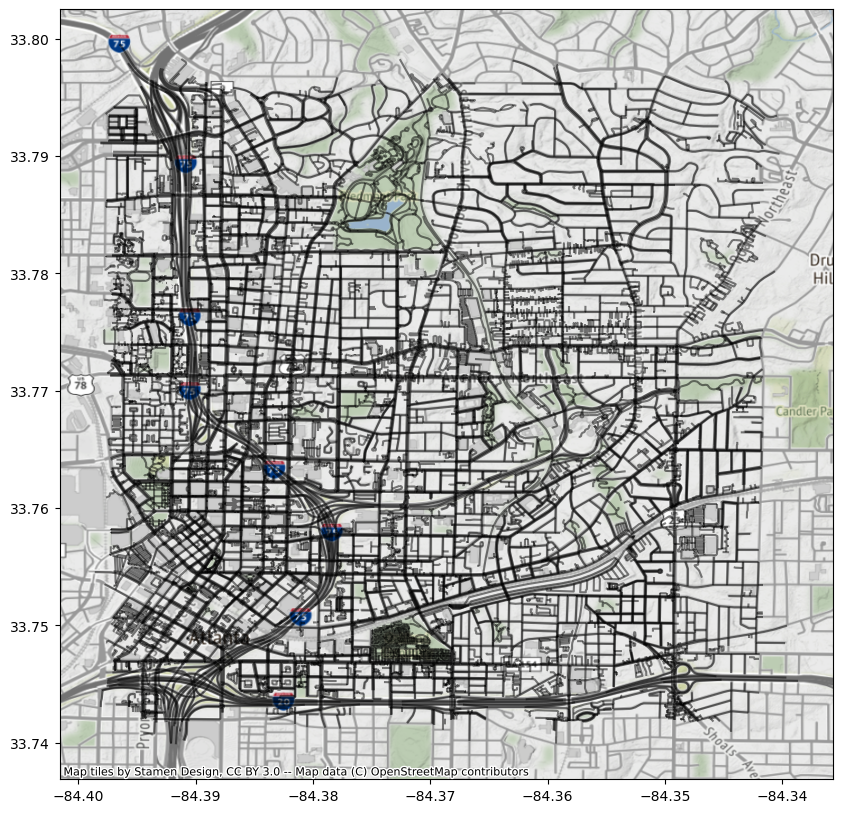

In [13]:
#gdf.to_crs('epsg:4326',inplace=True)
ax = gdf.plot(figsize=(10,10),alpha=0.5,edgecolor='k')
cx.add_basemap(ax, crs=gdf.crs)

In [14]:
#create osm folder if it doesn't exist already
if not (export_fp / 'osm').exists():
    (export_fp / 'osm').mkdir(parents=True)

## Download OSM geometry using OSMnx and attribute data using Overpass API
More info about OSMnx: https://geoffboeing.com/2016/11/osmnx-python-street-networks/  
OSMnx documentation: https://osmnx.readthedocs.io/en/stable/index.html

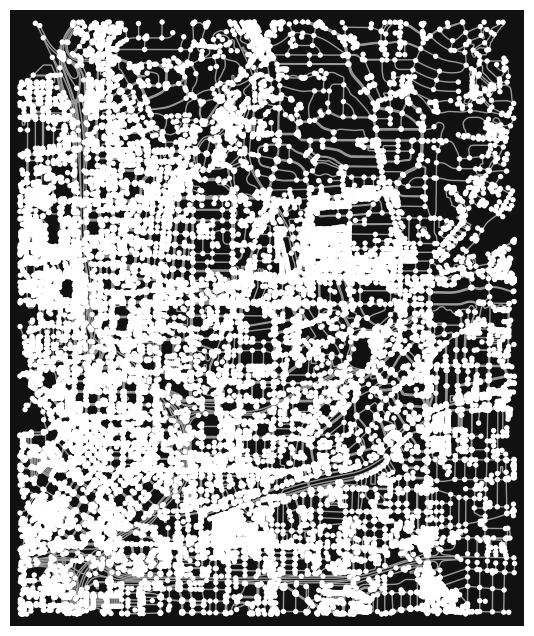

The bounding box is -84.39860534667969, 33.7398681640625, -84.33866119384766, 33.79953384399414


/Users/tannerpassmore/Documents/GitHub/BikewaySimDev/osm_dwnld.py:116: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'tags.', '')


In [15]:
osm_nodes, osm_links = download_osm(gdf)

In [16]:
#don't run if large network
#osm_links.explore()

### Which columns to keep?
1. Check for completion
1. Check for desired attributes (speed, bike lanes, etc.)
1. Filter to just those

In [17]:
#project to desired crs
network_length = osm_links.to_crs(crs).length
total_network_length = osm_links.to_crs(crs).length.sum()

#get pct complete weighted by total distance
attr_completion = osm_links.notna().apply(lambda col: col*network_length,axis=0).sum() / total_network_length
attr_completion.name = 'prop_complete'

#retrieve all complete fields
complete = list(attr_completion[attr_completion>0.95].index)
less_complete = list(attr_completion[attr_completion<=0.95].index)

#export attr completion csv
attr_completion.to_csv(export_fp / Path(f'osm/{studyarea_name}_attr_completion.csv'))

### Most attributes in OSM are empty

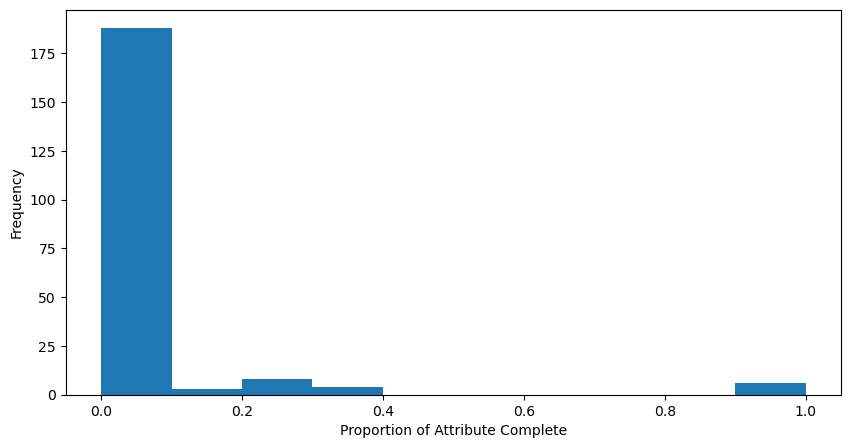

In [18]:
# Make boxplot
marks = np.array(attr_completion)

fig, axis = plt.subplots(figsize =(10, 5))
axis.hist(marks, bins = np.array([x for x in range(0, 110, 10)]) / 100)
plt.xlabel('Proportion of Attribute Complete')
plt.ylabel('Frequency')
# Displaying the graph
plt.show()

### Examine which attributes are present
Try 'maxspeed' or 'lanes'

In [19]:
#others to check: 'cycleway','lanes'
attributes_to_check = ['maxspeed']
osm_links.loc[osm_links[attributes_to_check].notna().any(axis=1),attributes_to_check+['geometry']].explore()

## Look at value counts to look at possible attribute values

In [20]:
osm_links['lanes'].value_counts()

4    1000
2     892
3     631
5     369
1     330
6     205
7      30
8       5
Name: lanes, dtype: int64

# Attributes to Export (reduces size of geopackage)
Add more as needed

In [21]:
# road attributes
road_columns = ['name','highway_1','oneway','lanes','maxspeed','bridge','crossing','sidewalk']

# parking attributes
parking_columns = [x for x in osm_links.columns.to_list() if 'parking' in x]

# bike attributes
bike_columns = [x for x in osm_links.columns.to_list() if (('cycle' in x) | ('bike' in x)) & ('motorcycle' not in x)]
foot_columns = [x for x in osm_links.columns.to_list() if ('foot' in x)]
bike_columns = bike_columns + foot_columns + ['lit']

osm_export = osm_links[complete+bike_columns+road_columns+parking_columns]

#remove columns with lists in them (handle these later)
for col in osm_export.columns.tolist():
    if list in [type(x) for x in osm_links.loc[:,col]]:
        osm_export.drop(columns=col,inplace=True)
        print(f"{col} column removed...")   

nodes column removed...


/var/folders/66/68r0k8s534v4gf9flsfnxnsr0000gn/T/ipykernel_15631/3010061787.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osm_export.drop(columns=col,inplace=True)


# Filter and Export

In [22]:
osm_nodes.to_file(export_fp / Path(f'osm/{studyarea_name}.gpkg'),layer='nodes')
osm_export.to_file(export_fp / Path(f'osm/{studyarea_name}.gpkg'),layer='links')

# Just Bike Infrastructure

In [14]:
#create copy
bike_lanes = osm_links.copy()

#drop no bicycle
bike_lanes = bike_lanes[bike_lanes['bicycle']!='no']
bike_lanes = bike_lanes[bike_lanes['lit']!='no']

#drop shared lanes "sharrows"
not_sharedlane = (bike_lanes[bike_columns] != 'shared_lane').all(axis=1)
bike_lanes = bike_lanes.loc[not_sharedlane,:]

#remove sidewalks unless bikes explicitly allowed
remove_sidewalks = (bike_lanes['footway'].isin(['sidewalk','crossing'])) & (bike_lanes['bicycle'] != 'yes')
bike_lanes = bike_lanes[-remove_sidewalks]

#need beltline and stuff
#bike_lanes.explore()

## Pickle all the attributes

In [15]:
with (export_fp / f'osm/{studyarea_name}_all_attr.pkl').open('wb') as fh:
        pickle.dump(osm_links,fh)

Remove columns with unsupported datatypes

In [16]:
# for col in osm_links.columns.tolist():
#     if list in [type(x) for x in osm_links.loc[:,col]]:
#         osm_links.drop(columns=col,inplace=True)
#         print(f"{col} column removed...")        

# Quick Export
- Remove restricted access roads
- Remove sidewalks

In [17]:
# links = osm_export.copy()

# #remove restricted access roads + sidewalks
# restr_access = links['highway'].isin(['motorway','motorway_link'])
# links = links[-restr_access]

# #remove sidewalks unless bikes explicitly allowed
# remove_sidewalks = (links['footway'].isin(['sidewalk','crossing'])) & (links['bicycle'] != 'yes')
# links = links[-remove_sidewalks]    

# #find service links that still have a name
# service_links_with_name = links[ (links['highway'] == 'service') & (links['name'].isnull() == False) ]

# osm_filter_method = ['primary','primary_link','residential','secondary','secondary_link',
#                     'tertiary','tertiary_link','trunk','trunk_link','cycleway','footway','path','pedestrian','steps'] 

# links = links[links["highway"].isin(osm_filter_method)]

# #add back in service links with a name
# links = links.append(service_links_with_name)

# #remove nodes that aren't in filtered links
# nodes = links['A'].append(links['B']).unique()
# osm_nodes_filt = osm_nodes[osm_nodes['osmid'].isin(nodes)]

# #export these two
# links.to_file(export_fp / f'osm/{studyarea_name}.gpkg',layer='quick_links')
# osm_nodes_filt.to_file(export_fp / f'osm/{studyarea_name}.gpkg',layer='quick_nodes')

Sometimes, there are duplicate attribute names in OSM. The below code drops duplicate column names by first appearance

In [18]:
#get rid of duplicate columns names
#overpass_links = overpass_links.iloc[:,overpass_links.columns.str.lower().duplicated(keep='first') == False]
